# **Fully Convolutional Neural Networks for Image Segmentation**

This project illustrates how to build a Fully Convolutional Neural Network for semantic image segmentation.

We will be using a pretrained VGG-16 network for the feature extraction path, then followed by an FCN-8 network for upsampling and generating the predictions. The output will be a label map (i.e. segmentation mask) with predictions for 3 classes.

![photo](https://github.com/MarwanMohamed95/Image-Semantic-Segmentation/blob/main/FCN_output.png?raw=true)

### Importing Libraries

In [ ]:
import os
import zipfile
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns
from google.colab.patches import cv2_imshow

### Loading the Dataset

We will be training the model on the [Oxford Pets - IIT dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) dataset. This contains pet images, their classes, segmentation masks.

This dataset is already included in TensorFlow Datasets and we can download it. The segmentation masks are included in versions 3 and above. The cell below will download the dataset and place the results in a dictionary named `dataset`. It will also collect information about the dataset is `info`.

In [ ]:
%%capture
# If you hit a problem with checksums, you can execute the following line first
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0

# download the dataset and get info
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
# the keys in the dataset
print(dataset.keys())

dict_keys(['test', 'train'])


In [ ]:
# see information about the dataset
# total_num_examples is 7349, trainset: 3680, testset: 3669
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

### Preprocessing the data

* Normalizing the pixel values

In [ ]:
# normalizes the input image pixel values to be from [0,1]. subtracts 1 from the mask labels to have a range from [0,2]
def normalize(input_image, input_mask):

  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

* Resizing and loading the images

In [ ]:
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (224, 224), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (224, 224), method='nearest')
  input_image, input_mask = normalize(input_image, input_mask)
  
  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (224, 224), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (224, 224), method='nearest')
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
# preprocess the train and test sets
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

BATCH_SIZE = 64
BUFFER_SIZE = 1000

# shuffle and group the train set into batches
training_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# do a prefetch to optimize processing
training_dataset = training_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# group the test set into batches
testing_dataset = test.batch(BATCH_SIZE)

### Visualizing Random image and its mask

In [ ]:
# class list of the mask pixels
class_names = ['pet', 'background', 'outline']

def display(display_list,titles=[], display_string=None):

  plt.figure(figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)
  
  plt.show()


def show_image_from_dataset(dataset):
  
  data = dataset.shuffle(100)
  for image, mask in data.take(1):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "True Mask"])

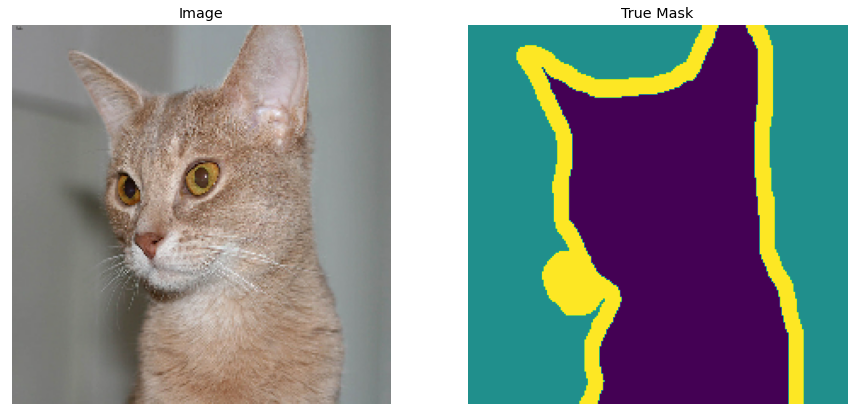

In [ ]:
# display an image from the train set
show_image_from_dataset(train)

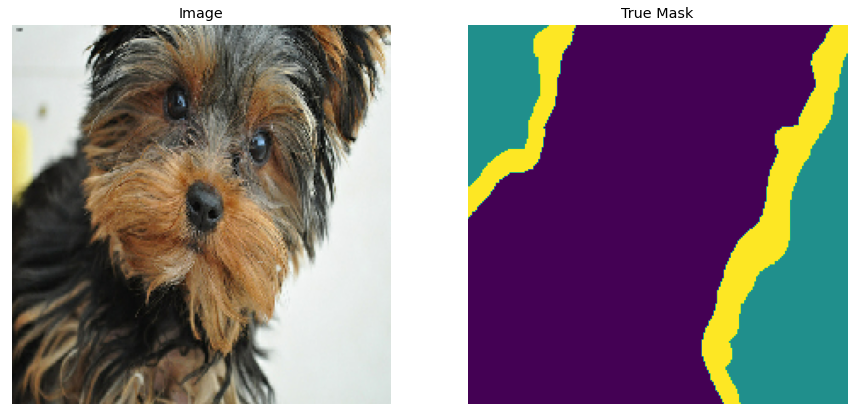

In [ ]:
# display an image from the test set
show_image_from_dataset(test)

## Building the Model

We will now build the model and prepare it for training. this will use a VGG-16 network for the encoder and FCN-8 for the decoder. This is the diagram as shown in class:

<img src='https://drive.google.com/uc?export=view&id=1lrqB4YegV8jXWNfyYAaeuFlwXIc54aRP' alt='fcn-8'>

* Loading the weights

In [ ]:
%%capture
# download the weights
!wget https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

# assign to a variable
vgg_weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

* Defining a bolck of conv layers and max pooling layer which we will use later 

In [ ]:
def block(x, n_convs, filters, kernel_size, activation, pool_size, pool_stride, block_name):
  
  for i in range(n_convs):
      x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same', name="{}_conv{}".format(block_name, i + 1))(x)
    
  x = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=pool_stride, name="{}_pool{}".format(block_name, i+1 ))(x)

  return x

### Define VGG-16 (Encoder)


* WE will create 5 blocks with increasing number of filters at each stage. 
* The number of convolutions, filters, kernel size, activation, pool size and pool stride will remain constant.
* WE will load the pretrained weights after creating the VGG 16 network.
* Additional convolution layers will be appended to extract more features.
* The output will contain the output of the last layer and the previous four convolution blocks.

In [ ]:
def VGG_16(image_input):
  
  # create 5 blocks with increasing filters at each stage. 
  x = block(image_input,n_convs=2, filters=64, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block1')
  p1= x

  x = block(x,n_convs=2, filters=128, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block2')
  p2 = x

  x = block(x,n_convs=3, filters=256, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block3')
  p3 = x

  x = block(x,n_convs=3, filters=512, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block4')
  p4 = x

  x = block(x,n_convs=3, filters=512, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block5')
  p5 = x

  # create the vgg model
  vgg  = tf.keras.Model(image_input , p5)

  # load the pretrained weights you downloaded earlier
  vgg.load_weights(vgg_weights_path) 

  # number of filters for the output convolutional layers
  n = 4096

  # our input images are 224x224 pixels so they will be downsampled to 7x7 after the pooling layers above.
  # we can extract more features by chaining two more convolution layers.
  c6 = tf.keras.layers.Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6")(p5)
  c7 = tf.keras.layers.Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7")(c6)

  # return the outputs at each stage. 
  return (p1, p2, p3, p4, c7)

### Building FCN 8 Decoder

Next, we will build the decoder using deconvolution layers. It will involve two summations before upsampling to the original image size and generating the predicted mask.

In [ ]:
def fcn8_decoder(convs, n_classes):

  # unpack the output of the encoder
  f1, f2, f3, f4, f5 = convs
  
  # upsample the output of the encoder then crop extra pixels that were introduced
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample the resulting tensor of the operation you just did
  o = (tf.keras.layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False ))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add()([o, o2])
  
  # upsample up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)

  # append a softmax to get the class probabilities
  o = (tf.keras.layers.Activation('softmax'))(o)

  return o

### The Final Model

We can now build the final model by connecting the encoder and decoder blocks.

In [ ]:
def segmentation_model():
  
  inputs = tf.keras.layers.Input(shape=(224,224,3,))
  convs = VGG_16(image_input=inputs)
  outputs = fcn8_decoder(convs, 3)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  
  return model

In [ ]:
# instantiate the model
model = segmentation_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [ ]:
# configuring the optimizer, loss and metrics for training
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# configuring the training parameters and train the model

TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 15
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE

# this will take around 20 minutes to run
model_history = model.fit(training_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=testing_dataset)

Epoch 1/15
57/57 [==============================] - 120s 2s/step - loss: 1.1018 - accuracy: 0.3556 - val_loss: 1.0672 - val_accuracy: 0.4256
Epoch 2/15
57/57 [==============================] - 117s 2s/step - loss: 0.9227 - accuracy: 0.5748 - val_loss: 0.8421 - val_accuracy: 0.6266
Epoch 3/15
57/57 [==============================] - 120s 2s/step - loss: 0.8112 - accuracy: 0.6786 - val_loss: 0.8006 - val_accuracy: 0.6888
Epoch 4/15
57/57 [==============================] - 122s 2s/step - loss: 0.7651 - accuracy: 0.7030 - val_loss: 0.7361 - val_accuracy: 0.7071
Epoch 5/15
57/57 [==============================] - 121s 2s/step - loss: 0.7380 - accuracy: 0.7090 - val_loss: 0.7789 - val_accuracy: 0.6913
Epoch 6/15
57/57 [==============================] - 121s 2s/step - loss: 0.7359 - accuracy: 0.7081 - val_loss: 0.7213 - val_accuracy: 0.7101
Epoch 7/15
57/57 [==============================] - 121s 2s/step - loss: 0.7014 - accuracy: 0.7231 - val_loss: 0.6362 - val_accuracy: 0.7454
Epoch 8/15
57

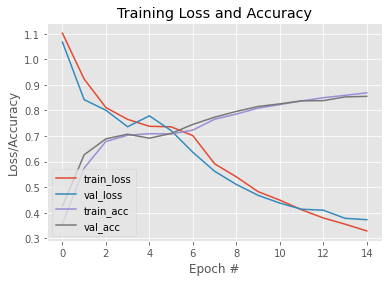

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), model_history.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), model_history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), model_history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), model_history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# saving the figure of accuracy and loss
plot_path = "plot.png"
plt.savefig(plot_path)

### Prediction

In [ ]:
# Unpacks the test dataset and returns the input images and segmentation masks
def get_test_image_and_annotation_arrays(NO_of_Batches):

  ds = testing_dataset.unbatch()
  ds = ds.batch(BATCH_SIZE*NO_of_Batches)
  
  images = []
  y_true_segments = []

  for image, annotation in ds.take(1).unbatch():
    y_true_segments.append(annotation.numpy())
    images.append(image.numpy())
  
  images = np.array(images)
  y_true_segments = np.array(y_true_segments)
  
  return images, y_true_segments
 

In [ ]:
# get the ground truth from the test set
y_true_images, y_true_segments = get_test_image_and_annotation_arrays(2)

In [ ]:
# Creates the segmentation mask by getting the channel with the highest probability.
def create_mask(pred_mask):
  
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(image, mask):
  
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

In [ ]:
# feed the test set to th emodel to get the predicted masks
results = model.predict(testing_dataset, steps=2)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]

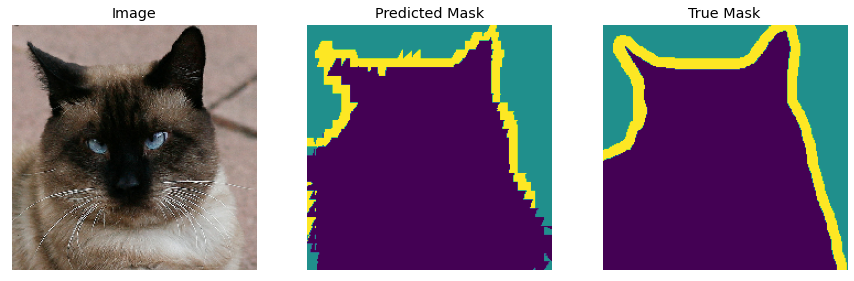

In [ ]:
# choosing random image from the dataset
random_image  = np.random.choice(128)

# Get the prediction mask
y_pred_mask = make_predictions(y_true_images[random_image], y_true_segments[random_image])
display([y_true_images[random_image], y_pred_mask, y_true_segments[random_image]], titles=["Image", "Predicted Mask", "True Mask"])

### Evaluating the model and Computing Metrics

The function below generates the IOU and dice score of the prediction and ground truth masks. it is given that:

$$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$
<br>
$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$

A small smoothening factor is introduced in the denominators to prevent possible division by zero.

In [ ]:
def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001
  for i in range(3):
    
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

In [ ]:
# Computing the class wise metrics
iou_list, dice_score_list = class_wise_metrics(y_true_segments[random_image], y_pred_mask)  
metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

display_string_list = ["{}: IOU: {}  Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
display_string = "\n".join(display_string_list) 
print(display_string)

pet: IOU: 0.9322168589792156  Dice Score: 0.9649194962657588
background: IOU: 0.8583690988172494  Dice Score: 0.9237875292968911
outline: IOU: 0.4829879377002971  Dice Score: 0.6513713644265603


### We Can conclude that the results isn't very well so we will try U-Net in the next notebook.
